In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
os.listdir('gdrive/My Drive/bert_study') #굳이 지드라이브랑 연동안해도됨

['bert_config.json',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt',
 'bert_model.ckpt.data-00000-of-00001',
 'spam.csv',
 'bert.h5',
 'squad_wordpiece_3 (1).h5',
 'squad_wordpiece_3.h5',
 'KorQuAD_v1.0_train.json',
 'KorQuAD_v1.0_dev.json',
 'korquad_wordpiece_3.h5',
 'bert_p.h5',
 'bert_final.h5',
 'bert1056.h5']

In [0]:
path='gdrive/My Drive/bert_study'

In [8]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [10]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=022cb8afcd01e2147f3bd899265265d6ab1ba1ef6d4c0d4d83434c29beb1f305
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=8221992b4f3217d9c31f40c0d5c296b9466cb13b9099036c04d999ebd26d5c62
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=c53cc0b0e307200c26dcf16f927d11042e3f7e8efcd9469b0ca11cbf28e4db62
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=4c304bc3db43912ff92b0d71b8febcbe5611916d7685a43a26ac0cc27e128832
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
import pandas as pd 

spam_csv=pd.read_csv(path+'/spam.csv',encoding='latin1')

In [82]:
spam_csv

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [0]:
del spam_csv['Unnamed: 2']
del spam_csv['Unnamed: 3']
del spam_csv['Unnamed: 4']
spam_csv['v1'] = spam_csv['v1'].replace(['ham','spam'],[0,1])



In [84]:
spam_csv

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [85]:
spam_csv.columns = ["label", "document"]
spam_csv

,label,document
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16#파인튜닝할땐 작게잡음
EPOCHS=2
LR=1e-5  #파인튜닝할땐 러닝레이트를 작게한다.

pretrained_path ="gdrive/My Drive/bert_study/"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "document"
LABEL_COLUMN = "label"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)
        #단어숫자단어숫자 만들어주기위해 vocab을 가져옴

In [0]:
tokenizer = Tokenizer(token_dict)

In [89]:
tokenizer.tokenize("You must get this free gift!") #문장앞에 cls 끝에 sep

['[CLS]', 'you', 'must', 'get', 'this', 'free', 'gift', '!', '[SEP]']

In [0]:
#숫자로 바꿔준다 넘버링
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(spam_csv['document'], spam_csv['label'], test_size=0.3, random_state=0)

In [0]:
from IPython.display import display

train_spam={"label": train_y,"document":train_x}
train_spam=pd.DataFrame(train_spam)

train_spam.to_csv("train_spam.csv", mode='w')

In [0]:
test_spam={"label": test_y,"document":test_x}
test_spam=pd.DataFrame(test_spam)
test_spam.to_csv("test_spam.csv", mode='w')

In [0]:
train_spam_load = pd.read_csv("train_spam.csv")
test_spam_load = pd.read_csv("test_spam.csv")

In [100]:
train_x, train_y = load_data(train_spam_load)
test_x, test_y = load_data(test_spam_load)

100%|██████████| 1672/1672 [00:00<00:00, 3663.83it/s]


In [101]:
train_x

[array([[  101, 33508, 92562, ...,     0,     0,     0],
        [  101, 13563,   119, ...,     0,     0,     0],
        [  101, 11530,   112, ...,     0,     0,     0],
        ...,
        [  101,   151, 10140, ...,     0,     0,     0],
        [  101,   131,   118, ...,     0,     0,     0],
        [  101, 12548, 33692, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint( #사전학습된 버트 모형을 불러옴
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [103]:
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 81315072    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2] #우리가가저온 버트모델, 인풋이 버트는 원래3개인(mask까지)데 파인투닝할떄는 마스크 빼고 인풋 2개만 가져온다.
  dense = model.layers[-3].output #마지막 레이어를 짤라낸다.뒤에서 3번째꺼 nsp-dense 까지 자른다.그것으로 아웃풋을할것이다. 버트를가져와서 분류를 할때는 마스크를 안쓴다.!그래서 거의 항상 이렇게쓰임

#자른모델에 레이어를 달아준다. 긍정인지 부정인지 알려주는 레이어
  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model
  

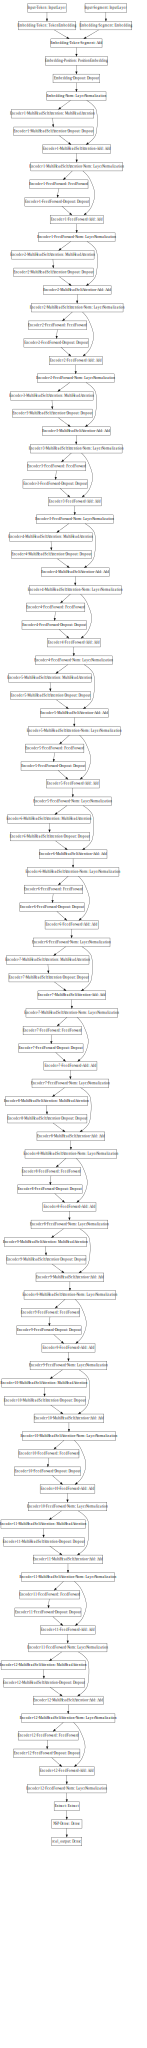

In [105]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


In [106]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 3900 samples, validate on 1672 samples
Epoch 1/2
3900/3900 [==============================] - 108s 28ms/step - loss: 0.3375 - acc: 0.8515 - val_loss: 0.0738 - val_acc: 0.9850
Epoch 2/2
3900/3900 [==============================] - 87s 22ms/step - loss: 0.0542 - acc: 0.9877 - val_loss: 0.0426 - val_acc: 0.9886


In [0]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [108]:
test_set = predict_load_data(test_spam_load)

100%|██████████| 1672/1672 [00:00<00:00, 4193.36it/s]


In [109]:
test_set

[array([[  101, 11279, 29388, ...,     0,     0,     0],
        [  101, 10140, 10103, ...,     0,     0,     0],
        [  101,   151, 14329, ...,     0,     0,     0],
        ...,
        [  101, 12787, 22556, ...,     0,     0,     0],
        [  101, 15517, 10429, ...,     0,     0,     0],
        [  101, 41775, 41775, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [0]:
#예측
preds = bert_model.predict(test_set)

In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def movie_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    predict_answer = np.round(np.ravel(predict), 0).item()
    
    if predict_answer == 0:
      print("this is ham")
    elif predict_answer == 1:
      print("this is spam.")

In [118]:
movie_evaluation_predict("free giftshop")

this is spam.


In [119]:
movie_evaluation_predict("i love you")

this is ham


In [120]:
movie_evaluation_predict("Free entry! you must buy this one")

this is spam.
